# Анализ данных в задаче кредитного скоринга

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.proportion import proportion_confint
import scipy

#### Загрузка и предварительная проверка данных для анализа

In [2]:
cols = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'default']
df = pd.read_csv('credit_card_default_analysis.csv', usecols=cols)

In [3]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,default
0,20000,2,2,1,24,1
1,120000,2,2,2,26,1
2,90000,2,2,2,34,0
3,50000,2,2,1,37,0
4,50000,1,2,1,57,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
default      30000 non-null int64
dtypes: int64(6)
memory usage: 1.4 MB


In [5]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,1.000000


In [6]:
df0 = df[df.default == 0]
df1 = df[df.default == 1]

#### Вспомогательные функции для формирования псевдовыборок и получения интервальных оценок статистик 

In [7]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [8]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

#### Вспомогательные функции для использования перестановочного критерия для двух несвязанных выборок

In [9]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [10]:
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [11]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [12]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

#### Вспомогательные функции для использования Z-критерия разностей долей

In [13]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [14]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [15]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

## 1. Размер кредитного лимита (LIMIT_BAL)

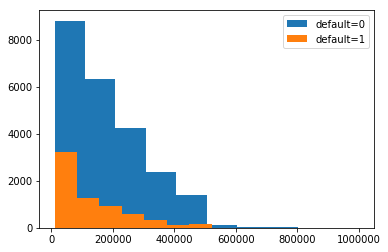

In [16]:
plt.hist(df0.LIMIT_BAL, label='default=0')
plt.hist(df1.LIMIT_BAL, label='default=1')
plt.legend()
plt.show()

Визуально разницы между медианными значениями кредитного лимита и распределениями кредитного лимита в выборках возвращенных и не возвращенных кредитов не видно.

### а) Проверка гипотезы о равенстве медианных значений кредитного лимита с помощью интервальной оценки разницы медианных значений на псевдовыборках

Проверим гипотезу о равенстве медианных значений кредитного лимита против правосторонней альтернативы. В данном случае имеет смысл рассмотреть правостороннюю альтернативу, исходя из предположения, что повышенные кредитные лимиты присваиваются платежеспособным клиентам.

In [17]:
np.random.seed(0)
bs0 = get_bootstrap_samples(df0.LIMIT_BAL.values, 1000)
bs1 = get_bootstrap_samples(df1.LIMIT_BAL.values, 1000)

In [18]:
median_diff = np.median(bs0, axis=1) - np.median(bs1, axis=1)

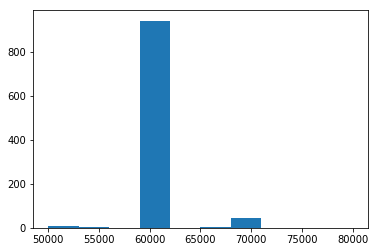

In [19]:
plt.hist(median_diff)
plt.show()

In [20]:
print u'Доверительный интервал для разницы медиан кредитного лимита:', \
stat_intervals(median_diff, 0.05)

Доверительный интервал для разницы медиан кредитного лимита: [60000. 70000.]


Доверительный интервал для разницы медиан кредитного лимита больше нуля. Поэтому можно уверенно отвергнуть нулевую гипотезу в пользу правосторонней альтернативы.

### б) Проверка гипотезы о равенстве распределений кредитного лимита с помощью перестановочного критерия проверки равенства средних

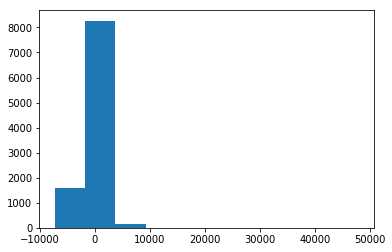

In [21]:
np.random.seed(0)
plt.hist(permutation_zero_dist_ind(df0.LIMIT_BAL.values, df1.LIMIT_BAL.values, max_combinations = 10000))
plt.show()

In [22]:
np.random.seed(0)
print u'Достигаемый уровень значимости гипотезы о равенстве распределений кредитного лимита:', \
permutation_test(df0.LIMIT_BAL.values, df1.LIMIT_BAL.values, max_permutations = 10000, alternative='greater')

Достигаемый уровень значимости гипотезы о равенстве распределений кредитного лимита: 0.0001


Достигаемый уровень значимости меньше 0.05, поэтому можно уверенно отвергнуть нулевую гипотезу в пользу правосторонней альтернативы.

### Выводы

Гипотезы о равенстве медианных значений кредитного лимита и о равенстве распределений кредитного лимита отвергнуты в пользу правосторонней альтернативы. Данный вывод имеет ограниченную практическую пользу, поскольку повышенный кредитный лимит присваивается клиентам с хорошей кредитной историей.

## 2. Пол (SEX)

Проверим гипотезу об одинаковом гендерном составе группы людей вернувших и не вернувших кредит против двухсторонней альтернативы, поскольку априори мы не знали о том, как пол влияет на возврат или невозврат кредита.

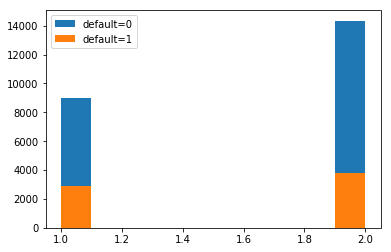

In [23]:
plt.hist(df0.SEX, label='default=0')
plt.hist(df1.SEX, label='default=1')
plt.legend()
plt.show()

Визуально заметна некоторая разница в соотношении полов среди групп людей, вернувших и не вернувших кредит.

### a) Проверка гипотезы об одинаковом гендерном составе группы людей вернувших и не вернувших кредит с помощью доверительных интервалов

In [24]:
print u'Доверительный интервал для доли женщин среди людей, вернувших кредит:', \
proportion_confint(sum(df0.SEX - 1), len(df0.SEX), method = 'normal')

Доверительный интервал для доли женщин среди людей, вернувших кредит: (0.6079080143666044, 0.6203919342723273)


In [25]:
print u'Доверительный интервал для доли женщин среди людей, не вернувших кредит:', \
proportion_confint(sum(df1.SEX - 1), len(df1.SEX), method = 'normal')

Доверительный интервал для доли женщин среди людей, не вернувших кредит: (0.5551371736238107, 0.5789797642905956)


Итервалы для долей женщин среди людей, вернувших и не вернувших кредит, не пересекаются. Это говорит об отвержении гипотезы об одинаковом гендерном составе групп в пользу двухсторонней альтернативы.

### б) Проверка гипотезы об одинаковом гендерном составе группы людей вернувших и не вернувших кредит с помощью Z-критерия для разности долей

In [26]:
print u'Доверительный интервал разницы долей женщин среди людей вернувших и не вернувших кредит:', \
proportions_diff_confint_ind(df0.SEX - 1, df1.SEX - 1)

Доверительный интервал разницы долей женщин среди людей вернувших и не вернувших кредит: (0.03363493274962867, 0.060548077974896725)


In [27]:
print u'Достигаемый уровень значимости для разницы долей женщин среди людей вернувших и не вернувших кредит:', \
proportions_diff_z_test(proportions_diff_z_stat_ind(df0.SEX - 1, df1.SEX - 1))

Достигаемый уровень значимости для разницы долей женщин среди людей вернувших и не вернувших кредит: 4.472866521609831e-12


Доверительный интервал разницы долей женщин не включает нулевое значение, а достигаемый уровень значимости меньше 0.05, поэтому мы уверенно отвергаем нулевую гипотезу в пользу двухсторонней альтернативы.

### Выводы

Гипотеза об одинаковом гендерном составе групп людей вернувших и не вернувших кредит отвергнута в пользу двухсторонней альтернативы. Данный вывод может иметь практический эффект, однако дифференцирование клиентов по полу может противоречить принципу недопустимости дискриминации.

## 3. Образование (EDUCATION)

Проверим гипотезу о том, что образование не влияет на то, вернет ли человек долг против двухсторонней альтернативы.

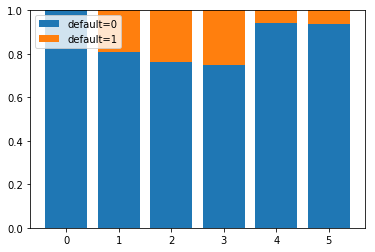

In [28]:
ct = pd.crosstab(df[df.EDUCATION != 6].EDUCATION, df[df.EDUCATION != 6].default)
plt.bar(ct.index, ct[0] / ct.sum(axis=1), label='default=0')
plt.bar(ct.index, ct[1] / ct.sum(axis=1), bottom=ct[0] / ct.sum(axis=1), label='default=1')
plt.legend()
plt.show()

Визуально заметна разница между долями возврата и не возврата долга для людей с разным образованием.

In [29]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(ct)

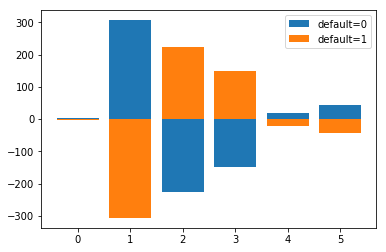

In [30]:
diff = ct - expected
plt.bar(ct.index, diff[0], label='default=0')
plt.bar(ct.index, diff[1], label='default=1')
plt.legend()
plt.show()

In [31]:
print u'Достигаемый уровень значимости для гипотезы о независимости возврата долга от образования:', p

Достигаемый уровень значимости для гипотезы о независимости возврата долга от образования: 3.835554410888646e-33


Достигаемый уровень значимости гипотезы меньше 0.05, поэтому мы уверенно отвергаем ее в пользу двухсторонней альтернативы.

### Выводы

Гипотеза о независимости возврата долга от образования отвергнута в пользу двухсторонней альтернативой. Наблюдаемая доля отдавших долг среди людей с докторской, магистерской степенями, начальным и прочим образованием выше ожидаемой. Наблюдаемая доля отдавших долг среди людей со степенью бакалавра и выпускниками школ ниже ожидаемой.

## 4. Семейное положение (MARRIAGE)

Проверим гипотезу об одинаковой доле холостяков в группах людей вернувших и не вернувших кредит против двухсторонней альтернативы.

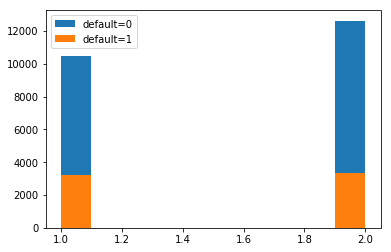

In [32]:
plt.hist(df0.MARRIAGE[df0.MARRIAGE.between(1, 2)], label='default=0')
plt.hist(df1.MARRIAGE[df1.MARRIAGE.between(1, 2)], label='default=1')
plt.legend()
plt.show()

Визуально на графике заметна разница в соотношении холостяков в группах людей, вернувших и не вернувших кредит.

### a) Проверка гипотезы об одинаковой доле холостяков в группах людей вернувших и не вернувших кредит с помощью доверительных интервалов

In [33]:
print u'Доверительный интервал для доли холостяков среди людей, вернувших кредит:', \
proportion_confint(sum(df0.MARRIAGE[df0.MARRIAGE.between(1, 2)] - 1),
                   len(df0.MARRIAGE[df0.MARRIAGE.between(1, 2)]),
                   method = 'normal')

Доверительный интервал для доли холостяков среди людей, вернувших кредит: (0.5405959742212102, 0.5534411205959159)


In [34]:
print u'Доверительный интервал для доли холостяков среди людей, не вернувших кредит:', \
proportion_confint(sum(df1.MARRIAGE[df1.MARRIAGE.between(1, 2)] - 1),
                   len(df1.MARRIAGE[df1.MARRIAGE.between(1, 2)]),
                   method = 'normal')

Доверительный интервал для доли холостяков среди людей, не вернувших кредит: (0.4982011689180104, 0.5224189624398633)


Итервалы для долей холостяков среди людей, вернувших и не вернувших кредит, не пересекаются. Это говорит об отвержении гипотезы об одинаковой доле холостяков в пользу двухсторонней альтернативы.

### б) Проверка гипотезы об одинаковой доле холостяков в группах людей вернувших и не вернувших кредит с помощью Z-критерия для разности долей

In [35]:
print u'Доверительный интервал разницы долей холостяков среди людей вернувших и не вернувших кредит:', \
proportions_diff_confint_ind(df0.MARRIAGE[df0.MARRIAGE.between(1, 2)] - 1,
                             df1.MARRIAGE[df1.MARRIAGE.between(1, 2)] - 1)

Доверительный интервал разницы долей холостяков среди людей вернувших и не вернувших кредит: (0.023001737874367205, 0.0504152255848851)


In [36]:
print u'Достигаемый уровень значимости для разницы долей холостяков среди людей вернувших и не вернувших кредит:', \
proportions_diff_z_test(proportions_diff_z_stat_ind(df0.MARRIAGE[df0.MARRIAGE.between(1, 2)] - 1,
                                                    df1.MARRIAGE[df1.MARRIAGE.between(1, 2)] - 1))

Достигаемый уровень значимости для разницы долей холостяков среди людей вернувших и не вернувших кредит: 1.448514344026819e-07


Доверительный интервал разницы долей холостяков не включает нулевое значение, а достигаемый уровень значимости меньше 0.05, поэтому мы уверенно отвергаем нулевую гипотезу в пользу двухсторонней альтернативы.

### Выводы 

Гипотеза об одинаковой доле холостяков в группах людей вернувших и не вернувших кредит отвергнута в пользу двухсторонней альтернативы. Данный вывод может иметь практический эффект, однако дифференцирование клиентов по семейному статусу может противоречить принципу недопустимости дискриминации.

## 5. Возраст (AGE)

Проверим гипотезу о равенстве медианных значений и о равенстве распределений возрастов людей против двухсторонней альтернативы.

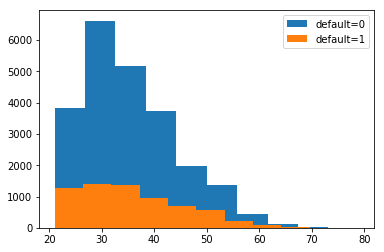

In [37]:
plt.hist(df0.AGE, label='default=0')
plt.hist(df1.AGE, label='default=1')
plt.legend()
plt.show()

Визуально разницы между медианами и распределениями не заметно.

### а) Проверка гипотезы о равенстве медианных значений возрастов людей с помощью интервальной оценки разницы медианных значений на псевдовыборках

In [38]:
np.random.seed(0)
bs0 = get_bootstrap_samples(df0.AGE.values, 1000)
bs1 = get_bootstrap_samples(df1.AGE.values, 1000)

In [39]:
median_diff = np.median(bs0, axis=1) - np.median(bs1, axis=1)

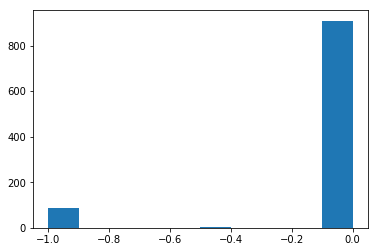

In [40]:
plt.hist(median_diff)
plt.show()

In [41]:
print u'Доверительный интервал для разницы медиан возрастов:', \
stat_intervals(median_diff, 0.05)

Доверительный интервал для разницы медиан возрастов: [-1.  0.]


Доверительный интервал включает нулевое значение, поэтому нельзя уверенно говорит об отвержении нулевой гипотезы о равенстве медианных значений возрастов людей в пользу двухсторонней альтернативы.

### б) Проверка гипотезы о равенстве распределений возрастов людей с помощью перестановочного критерия проверки равенства средних

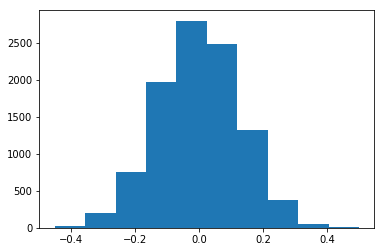

In [42]:
np.random.seed(0)
plt.hist(permutation_zero_dist_ind(df0.AGE.values, df1.AGE.values, max_combinations = 10000))
plt.show()

In [43]:
np.random.seed(0)
print u'Достигаемый уровень значимости гипотезы о равенстве распределения возрастов людей:', \
permutation_test(df0.AGE.values, df1.AGE.values, max_permutations = 10000)

Достигаемый уровень значимости гипотезы о равенстве распределения возрастов людей: 0.0151


Достигаемый уровень значимости меньше 0.05, поэтому можно отвергнуть гипотезу о равенстве распределения возрастов людей в пользу двухсторонней альтернативы.

### Выводы

Гипотеза о равенстве медианного значения возрастов не отвергнута. Гипотеза о равенстве распределения возрастов отвергнута. Однако практическая значимость невелика, поскольку, судя по доверительному интервалу, абсолютное значение разницы медиан возрастов не превышает одного года. Кроме того, дифференцирование клиентов по возрасту может противоречить принципу недопустимости дискриминации.